In [14]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy.stats import entropy
import networkit as nk #more efficient
import pickle
import statistics
from sklearn.utils import shuffle
from scipy.stats import pearsonr, spearmanr
from sklearn.utils import shuffle


#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import preprocessing_Origins,is_day,time_series_henColumn_tsRow, is_WG_open, is_day, chi2_distance
import config_exp2 as config

C:\Users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
C:\Users\camil\anaconda3\lib\site-packages\gensim\matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
C:\Users\camil\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


2


In [43]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
li_tracking_date = config.li_tracking_date
print(id_run)
path_extracted_data_visual = os.path.join(path_extracted_data,'CHi2Valid')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual):
    os.makedirs(path_extracted_data_visual)

change the configuration file if not done yet!
EXP2_


In [42]:
path_extracted_data

'G:\\VPHI\\Welfare\\2- Research Projects\\Camille Montalcini\\Origins.GS\\DataOutput\\TrackingSystem\\EXP2_'

#computing chi2-distance
def chi2_distance(l1,l2,remove_warning=False):
    '''compute the following distance: d(x,y) = sum( (xi-yi)^2 / (xi+yi) ) / 2
    allow to be flexible regarding chi2distance for exemple for lda mixture of topics'''
    if len(l1)!=len(l2):
        print('your two vectors must have same length')
        sys.exit()
    if (abs(sum(l1)-1)>0.01) | (abs(sum(l2)-1)>0.01):
        if not remove_warning:
            print('WARNING: your two vectors must be normalized (sumed to one) for now their sum are:',abs(sum(l1)-1),'and', abs(sum(l2)-1))
            print('We will normalise them so that their sum equals one')
        l1 = [i/sum(l1) for i in l1]
        l2 = [i/sum(l2) for i in l2]
    d = sum([(l1[i]-l2[i])**2 / ((l1[i]+l2[i])+0.000000000001) for i in range(len(l1))])/2
    return(d)
m1 = [1,1,2,2,3,3,3,3]
m2 = [1,3,3,3,3,3,2,2]
l1 = [Counter(m1)[i]/len(m1) for i in range(1,5+1)]
l2 = [Counter(m2)[i]/len(m2) for i in range(1,5+1)]
chi2_distance(l1,l2)

In [4]:
#with weight on the edge: TODO AND READ
#https://stellargraph.readthedocs.io/en/stable/demos/node-classification/node2vec-weighted-node-classification.html

In [5]:
# is the order important?
l1 = [0.25, 0.25, 0.0, 0.5, 0.0]
l2 = [0.125, 0.25, 0.0, 0.625, 0.0]
print(l1,l2)
chi2_distance(l1,l2)

[0.25, 0.25, 0.0, 0.5, 0.0] [0.125, 0.25, 0.0, 0.625, 0.0]


0.02777777777771605

In [6]:
l1 = [0.25, 0.25, 0.5, 0.0, 0.0]
l2 = [0.125, 0.25, 0.625, 0.0, 0.0]
print(l1,l2)
chi2_distance(l1,l2)

[0.25, 0.25, 0.5, 0.0, 0.0] [0.125, 0.25, 0.625, 0.0, 0.0]


0.02777777777771605

# download data

In [7]:
df = pd.read_csv(os.path.join(path_extracted_data, 'df_longformatALLdailyChi2validation.csv'), sep=',') 
df = df[~df['duration_2_Zone_min'].isnull()]
display(df['ExperimentID'].value_counts())
print(df.shape)
display(df.head(3))

Exp2    4446
Exp1    4107
Exp3    3492
Name: ExperimentID, dtype: int64

(12045, 24)


,VTDperhour,proptime_2_Zone,proptime_5_Zone,chi2distance,severity,gap,HenID,early_death,ExperimentID,DOA,...,mid_cum_Z4_h_Morning,weight,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,dur_values,dur_values_norm,chi2distance_notused
0,3.185185,66.168724,2.014403,0.189384,0.0,0.0,EXP2_hen_1,0.0,Exp2,167,...,5.365556,1691.7,0.0,535.966667,201.916667,55.800000,16.316667,"[0.0, 535.9666666666667, 201.91666666666663, 5...","[0.0, 0.662, 0.249, 0.069, 0.02]",0.332015
1,3.555556,50.691358,21.448560,0.081126,0.0,0.0,EXP2_hen_1,0.0,Exp2,168,...,5.242778,1691.7,0.0,410.600000,171.883333,53.783333,173.733333,"[0.0, 410.6, 171.88333333333333, 53.7833333333...","[0.0, 0.507, 0.212, 0.066, 0.214]",0.200818
2,4.592593,59.014403,6.802469,0.133183,0.0,0.0,EXP2_hen_1,0.0,Exp2,169,...,5.168333,1691.7,0.0,478.016667,220.283333,56.600000,55.100000,"[0.0, 478.01666666666665, 220.28333333333333, ...","[0.0, 0.59, 0.272, 0.07, 0.068]",0.265561


In [8]:
li_dur = [i for i in df.columns if 'duration_' in i]
print(li_dur)
df['sumdur'] = df[li_dur].sum(axis=1)
display(df[['sumdur']+li_dur].head(3))
for i in li_dur:
    df['Prop'+i.replace('duration_','Z').replace('_Zone_min','')] = df.apply(lambda x: x[i]/x['sumdur'], axis=1)
li_prop = [i for i in df.columns if i.startswith('Prop')]
li_prop

['duration_1_Zone_min', 'duration_2_Zone_min', 'duration_3_Zone_min', 'duration_4_Zone_min', 'duration_5_Zone_min']


,sumdur,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min
0,810.0,0.0,535.966667,201.916667,55.800000,16.316667
1,810.0,0.0,410.600000,171.883333,53.783333,173.733333
2,810.0,0.0,478.016667,220.283333,56.600000,55.100000


['PropZ1', 'PropZ2', 'PropZ3', 'PropZ4', 'PropZ5']

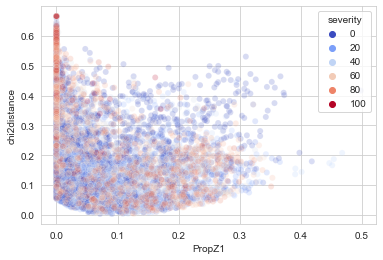

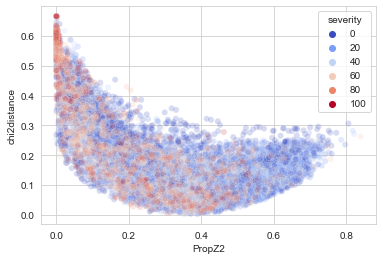

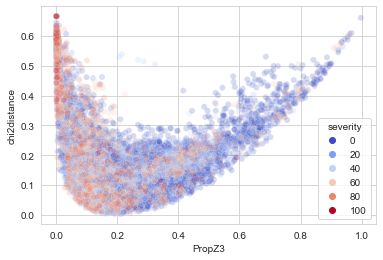

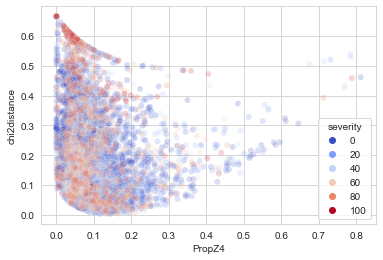

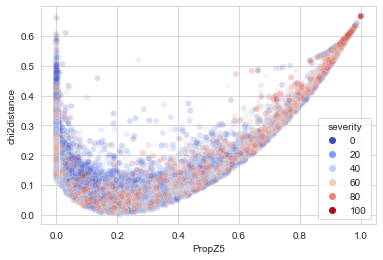

In [9]:
for i in li_prop:
    sns.scatterplot(y='chi2distance', x=i, hue='severity', data=df, palette=sns.color_palette("coolwarm", as_cmap=True),
                    alpha=0.2);
    plt.show()

(100, 7)


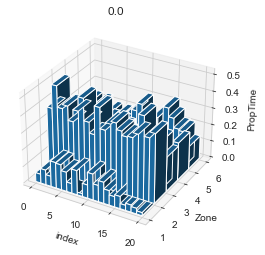

(100, 7)


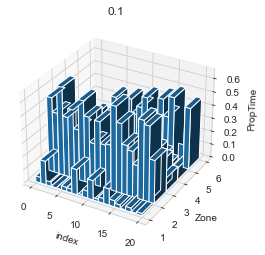

(100, 7)


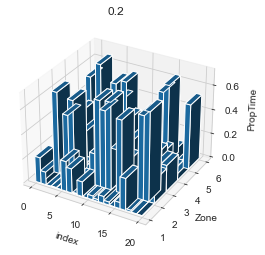

(100, 7)


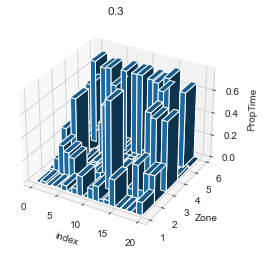

(100, 7)


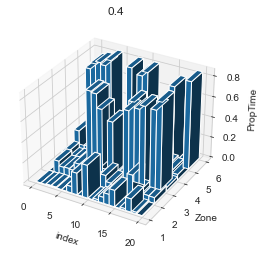

(100, 7)


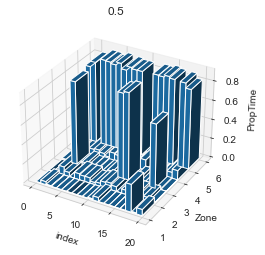

(100, 7)


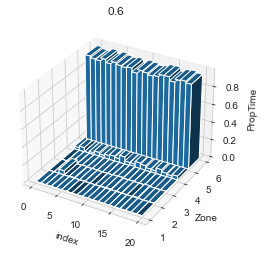

(140, 9)


,chi2distance,DOA,severity,PropZ1,PropZ2,PropZ3,PropZ4,PropZ5,index
281,0.0,168,0.0,0.054115,0.384053,0.218827,0.100494,0.24251,0
2378,0.0,305,7.0,0.089048,0.522798,0.123194,0.129921,0.13504,1


C:\Users\camil\anaconda3\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


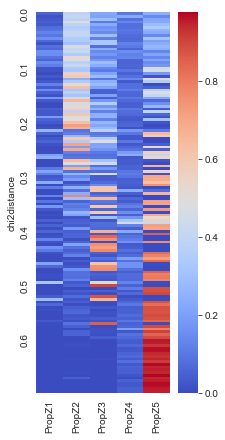

In [52]:
#TODO: add color based on severity
li_df = []
nbr = 20
rs = 123
df_plt_ = df[['chi2distance','DOA','severity']+li_prop].copy()
df_plt_['chi2distance'] = df_plt_['chi2distance'].map(lambda x: round(x,1))
df_plt_ = shuffle(df_plt_, random_state=rs)
for i in range(0,10,1):
    df_plt = df_plt_.copy()
    df_plt = df_plt[df_plt['chi2distance']==i/10].iloc[0:nbr]
    if df_plt.shape[0]==nbr:
        fig = plt.figure()
        ax1 = fig.add_subplot(111, projection='3d')
        li_df.append(df_plt)
        df_plt['index'] = range(0,df_plt.shape[0])
        df_plt = pd.melt(df_plt, id_vars=['DOA','chi2distance','severity','index'], value_vars=li_prop, value_name='PropTime')
        df_plt['Zone'] = df_plt['variable'].map(lambda x: int(re.findall(r'\d+',x)[0]))
        #df_plt.sort_values('',inplace=True, ascending=False)
        print(df_plt.shape)
        df_plt.head(2)
        x3 = df_plt['index'].tolist()
        y3 = df_plt['Zone'].tolist() 
        z3 = np.zeros(len(x3)) #start at 0 on the z axis

        #x, dy, dz represent the width, depth, and height (dimensions in x, y and z)
        dx = np.ones(len(x3))
        dy = np.ones(len(x3))
        dz = df_plt['PropTime'].tolist() #chose the height of the z axis
        ax1.bar3d(x3, y3, z3, dx, dy, dz)
        ax1.set_xlabel('index')
        ax1.set_ylabel('Zone')
        ax1.set_zlabel('PropTime')
        plt.title(i/10)
        plt.show()
df_hm = pd.concat([li_df[0],li_df[1]])
for i in range(2,len(li_df)):
    df_hm = pd.concat([df_hm,li_df[i]])
print(df_hm.shape)
display(df_hm.head(2))
df_hm.sort_values('chi2distance',inplace=True)
M = df_hm[['PropZ1','PropZ2','PropZ3','PropZ4','PropZ5']]
plt.figure(figsize=(3,7))
sns.heatmap(M, xticklabels=['PropZ1','PropZ2','PropZ3','PropZ4','PropZ5'], 
            yticklabels=[df_hm['chi2distance'].tolist()[i] if i%20==0 else '' for i in range(0,df_hm.shape[0])], 
            cmap=sns.color_palette("coolwarm", as_cmap=True),annot=False) #to annotate value in each cell
plt.ylabel('chi2distance')
plt.savefig(os.path.join(path_extracted_data_visual,'Heatmap_chi2distance.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

(150, 6)


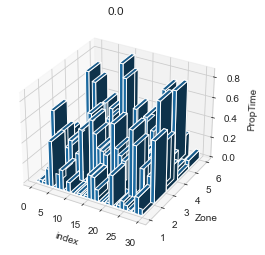

(150, 6)


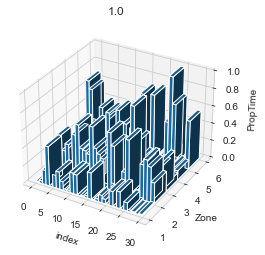

(150, 6)


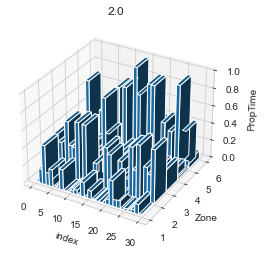

(150, 6)


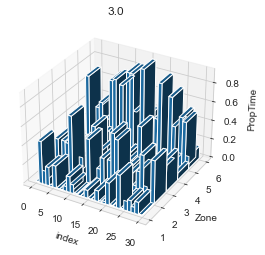

(150, 6)


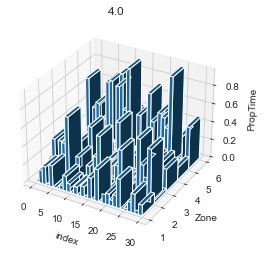

(150, 6)


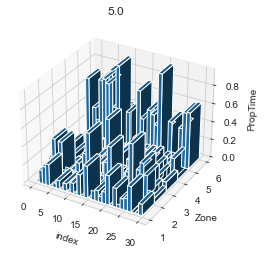

(150, 6)


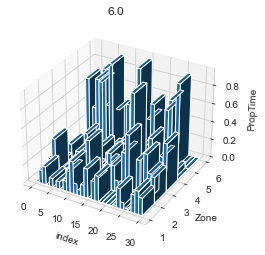

(150, 6)


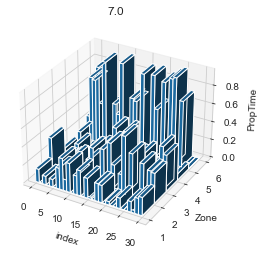

(150, 6)


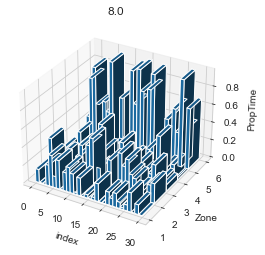

(150, 6)


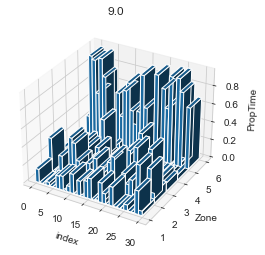

(300, 8)


,DOA,severity,PropZ1,PropZ2,PropZ3,PropZ4,PropZ5,index
10701,276,66.0,0.007816,0.150125,0.107172,0.035939,0.698948,0
5420,170,0.0,0.034667,0.617426,0.291870,0.044407,0.011630,1


C:\Users\camil\anaconda3\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


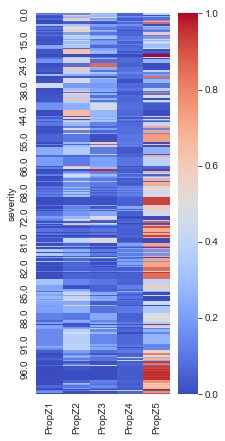

In [75]:
#severity
li_df = []
nbr = 30
rs = 12345
df_plt_ = df[['DOA','severity']+li_prop].copy()
df_plt_ = shuffle(df_plt_, random_state=rs)
for i in range(0,100,10):
    df_plt = df_plt_.copy()
    df_plt = df_plt[df_plt['severity']>=i].iloc[0:nbr]
    if df_plt.shape[0]==nbr:
        fig = plt.figure()
        ax1 = fig.add_subplot(111, projection='3d')
        li_df.append(df_plt)
        df_plt['index'] = range(0,df_plt.shape[0])
        df_plt = pd.melt(df_plt, id_vars=['DOA','severity','index'], value_vars=li_prop, value_name='PropTime')
        df_plt['Zone'] = df_plt['variable'].map(lambda x: int(re.findall(r'\d+',x)[0]))
        #df_plt.sort_values('',inplace=True, ascending=False)
        print(df_plt.shape)
        df_plt.head(2)
        x3 = df_plt['index'].tolist()
        y3 = df_plt['Zone'].tolist() 
        z3 = np.zeros(len(x3)) #start at 0 on the z axis

        #x, dy, dz represent the width, depth, and height (dimensions in x, y and z)
        dx = np.ones(len(x3))
        dy = np.ones(len(x3))
        dz = df_plt['PropTime'].tolist() #chose the height of the z axis
        ax1.bar3d(x3, y3, z3, dx, dy, dz)
        ax1.set_xlabel('index')
        ax1.set_ylabel('Zone')
        ax1.set_zlabel('PropTime')
        plt.title(i/10)
        plt.show()
df_hm = pd.concat([li_df[0],li_df[1]])
for i in range(2,len(li_df)):
    df_hm = pd.concat([df_hm,li_df[i]])
print(df_hm.shape)
display(df_hm.head(2))
df_hm.sort_values('severity',inplace=True)
M = df_hm[['PropZ1','PropZ2','PropZ3','PropZ4','PropZ5']]
plt.figure(figsize=(3,7))
sns.heatmap(M, xticklabels=['PropZ1','PropZ2','PropZ3','PropZ4','PropZ5'], 
            yticklabels=[df_hm['severity'].tolist()[i] if i%20==0 else '' for i in range(0,df_hm.shape[0])], 
            cmap=sns.color_palette("coolwarm", as_cmap=True),annot=False) #to annotate value in each cell
plt.ylabel('severity')
plt.savefig(os.path.join(path_extracted_data_visual,'Heatmap_severity.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

In [69]:
#compared to the daily mean? mean of another flock? of all data? 
#or square meter to use no other prior info than the structure itself? easier to interpret, thats what I'll do
df[li_prop].describe()

,PropZ1,PropZ2,PropZ3,PropZ4,PropZ5
count,12045.000000,12045.000000,12045.000000,12045.000000,12045.000000
mean,0.050860,0.342462,0.236883,0.080886,0.288909
std,0.073460,0.189329,0.163835,0.062505,0.272572
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.186074,0.115390,0.045870,0.048730
50%,0.016331,0.360535,0.219093,0.065648,0.206630
75%,0.068936,0.495778,0.321259,0.095972,0.475413
max,0.497808,0.839528,0.997552,0.816444,1.000000


In [ ]:
#sns.lmplot(x ='severity', y ='chi2distance', data = df, hue ='ExperimentID', order=2);
#TODO: at which level of severity does the effect on mvt start? or simpler: doe sthe effect get stronger when KBF is higher?
#drift depend on initial level of the trend latent process
#sns.scatterplot(y='chi2distance', x='severity', hue='ExperimentID', data=df, alpha=0.3);
#sns.lmplot(x ='severity', y ='proptime_5_Zone', data = df, hue ='ExperimentID', order=2);